In [24]:
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import sys
sys.path.append("../")
import os
from tqdm import tqdm_notebook

from normal_prior import DecisionMaker

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import matplotlib
matplotlib.style.use('classic')

In [25]:
def get_us(dm, method='newton'):
    a1s = np.arange(0.01, 1, 0.01)
    ts, us, ps = [], [], []
    for a1 in a1s:
        tobl = dm.group_oblivious_threshold(a1)
        tdp = dm.dp_threshold(a1)
        topt = dm.opt1_threshold(a1, method=method)
        tgamma_obl = dm.gamma_threshold(a1)
        tgamma_opt = dm.gamma_opt_threshold(a1, method=method)
        ts.append([tobl, tdp, topt, tgamma_obl, tgamma_opt])
        us.append([dm.utility1(tobl, a1), dm.utility1(tdp, a1), dm.utility1(topt, a1),\
                   dm.utility1(tgamma_obl, a1), dm.utility1(tgamma_opt, a1)])
        ps.append([dm.selection_proba1(tobl), dm.selection_proba1(tdp), dm.selection_proba1(topt),\
            dm.selection_proba1(tgamma_obl), dm.selection_proba1(tgamma_opt)])
    return a1s, np.array(ts).T, np.array(us).T, np.array(ps).T

def plot_us(a1s, us):
    plt.figure(figsize=(3,3))
    plt.plot(a1s, us[2], 'k-', label='$\\mathrm{opt}$')
    plt.plot(a1s, us[4], 'k:', label='$\\gamma$-$\\mathrm{opt}$')
    plt.plot(a1s, us[1], 'r-', label='$\\mathrm{dp}$')
    plt.plot(a1s, us[3], 'r-.', label='$\\gamma$-$\\mathrm{obl}$')
    plt.plot(a1s, us[0], 'b--', label='$\\mathrm{obl}$')
    plt.xlabel("$\\alpha$", fontsize=16)
    plt.ylabel("$\mathcal{U}$", fontsize=16)
    plt.legend(fontsize=16)
    
def plot_ps(a1s, ps):
    plt.figure(figsize=(3,3))
    plt.plot(a1s, ps[0,2], 'k-', label='$\\mathrm{opt}$')
    plt.plot(a1s, ps[0,4], 'k:', label='$\\gamma$-$\\mathrm{opt}$')
    plt.plot(a1s, ps[0,1], 'r-', label='$\\mathrm{dp}$')
    plt.plot(a1s, ps[0,3], 'r-.', label='$\\gamma$-$\\mathrm{obl}$')
    plt.plot(a1s, ps[0,0], 'b--', label='$\\mathrm{obl}$')
    plt.xlabel("$\\alpha$", fontsize=16)
    plt.ylabel("$x_A$", fontsize=16)
    plt.legend(fontsize=16)
    
def f(xs):
    xs_ = []
    for x in xs:
        if x <= 1:
            xs_.append(x)
        else:
            xs_.append(1)
    return xs_

def dU(alpha, mu, sigmat, p):
    ppf = st.norm.ppf(1-alpha)
    return p[0] / alpha * (ppf * (sigmat[0] - sigmat[1]))

def U(alpha, mu, sigmat, p):
    ppf = st.norm.ppf(1-alpha)
    return mu + st.norm.pdf(ppf)/alpha * np.sum(sigmat * p)
    
def upper_bound(alpha, mu, sigmat, p):
    return 1. - alpha * dU(alpha, mu, sigmat, p) / U(alpha, mu, sigmat, p)

def upper_bound2(alpha, mu, sigmat, p):
    return 1. + (1 - alpha) * dU(alpha, mu, sigmat, p) / U(alpha, mu, sigmat, p)

# Section 4.1 (common prior, no bias)

In [4]:
beta = [0,0]
dm = DecisionMaker(mu=[1, 1], sigma=[1,1], sigmag=[3, 0.2], beta=beta, pg=[0.4, 0.6])
a1s, ts, us, ps = get_us(dm, method='bisect')

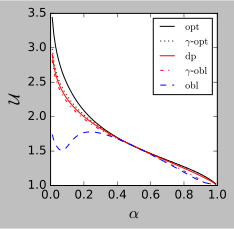

In [5]:
plot_us(a1s, us)
plt.legend(fontsize=10)
# plt.savefig('../fig/normal-u1.pdf', bbox_inches='tight')

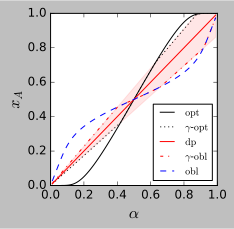

In [6]:
plot_ps(a1s, ps)
beta = 0.8
pa, pb = dm.pg
plt.fill_between(a1s,  f(a1s / (pa + beta* pb)), f(a1s * beta /(pa * beta + pb)), color='r', alpha=0.1,)
plt.legend(fontsize=10, loc='lower right')
# plt.savefig('../fig/normal-x-1-stage.pdf', bbox_inches='tight')

In [7]:
sigmaB = 0.2
uk = []
for k in tqdm_notebook([2,5,10,15]):
    dm = DecisionMaker(mu=[1, 1], sigma=[1,1], sigmag=[sigmaB * k, sigmaB], beta=[0,0], pg=[0.4, 0.6])
    a1s, ts, us, ps = get_us(dm, method='bisect')
    uk.append(us)

Calculate the upper-bound for $\sigma_B = 3$

In [8]:
bounds = upper_bound(a1s, 1, dm.sigma**2/ np.sqrt(dm.sigmag**2 + dm.sigma**2), dm.pg)
bounds2 = upper_bound2(a1s, 1, dm.sigma**2/np.sqrt(dm.sigmag**2 + dm.sigma**2), dm.pg)

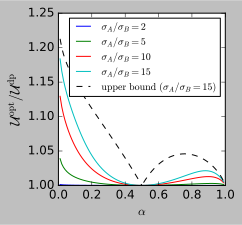

In [22]:
plt.figure(figsize=(3,3))
for i,k in tqdm_notebook(enumerate([2,5,10,15])):
    plt.plot(a1s, uk[i][2] / uk[i][1], label="$\\sigma_A / \\sigma_B={}$".format(k))
plt.plot(a1s[:50], bounds[:50], 'k--')
plt.plot(a1s[50:], bounds2[50:], 'k--', label='$\mathrm{upper\ bound}\ (\sigma_A/\sigma_B=15)$')
plt.legend(loc='upper right', fontsize=10)
plt.xlabel("$\\alpha$")
plt.ylabel("$\mathcal{U}^\mathrm{opt}  / \mathcal{U}^\mathrm{dp}$", fontsize=14)
plt.savefig('../fig/normal-u1-ratio-sigma-opt.pdf', bbox_inches='tight')

Text(0, 0.5, '$\\mathcal{U}^\\mathrm{dp}  / \\mathcal{U}^\\mathrm{obl}$')

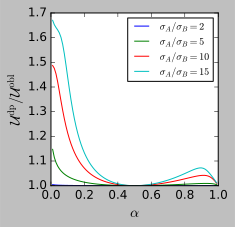

In [10]:
plt.figure(figsize=(3,3))
for i,k in tqdm_notebook(enumerate([2,5,10,15])):
    plt.plot(a1s, uk[i][1] / uk[i][0], label="$\\sigma_A / \\sigma_B={}$".format(k))
plt.legend(loc='upper right', fontsize=10)
plt.xlabel("$\\alpha$", fontsize=14)
plt.ylabel("$\mathcal{U}^\mathrm{dp}  / \mathcal{U}^\mathrm{obl}$", fontsize=14)
# plt.savefig('../fig/normal-u1-ratio-sigma-obl.pdf', bbox_inches='tight')

# Section 4.1 (common prior,  biased)

Case 1. $\beta_A = \beta_B$

In [57]:
beta = [-1,-1]
dm = DecisionMaker(mu=[1, 1], sigma=[1,1], sigmag=[3, 0.2], beta=beta, pg=[0.4, 0.6])
a1s, ts, us, ps = get_us(dm, method='bisect')

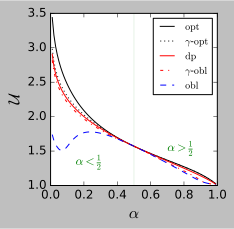

In [58]:
plot_us(a1s, us)
sigmasum = dm.sigmasum
aobl = st.norm.cdf(-(beta[0] - beta[1]) / (sigmasum[0] - sigmasum[1]))
plt.axvline(0.5, alpha=0.1, color='g')
plt.text(x=0.15, y=1.3, s='$\\alpha < \\frac{1}{2}$', fontsize=12, color='g')
plt.text(x=0.7, y=1.5, s='$\\alpha > \\frac{1}{2}$', fontsize=12, color='g')

plt.legend(fontsize=10)
plt.savefig('../fig/appendix/biasA_equal_biasB.pdf', bbox_inches='tight')

Case 2. $\beta_A > \beta_B$

In [59]:
beta=[-1,0]
dm = DecisionMaker(mu=[1, 1], sigma=[1,1], sigmag=[3, 0.2], beta=beta, pg=[0.4, 0.6])
a1s, ts, us, ps = get_us(dm, method='bisect')

0.32033931378977537


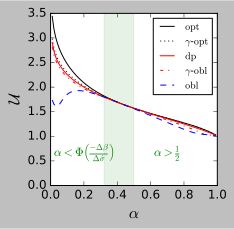

In [60]:
plot_us(a1s, us)
sigmasum = dm.sigmasum
aobl = 1 - st.norm.cdf((beta[0] - beta[1]) / (sigmasum[1] - sigmasum[0]))
plt.text(x=0.02, y=0.6, s='$\\alpha < \\Phi\\left(\\frac{-\\Delta\\beta}{\\Delta\\hat\\sigma}\\right)$',\
         fontsize=12,  color='g')
plt.text(x=0.62, y=0.6, s='$\\alpha > \\frac{1}{2}$', fontsize=12, color='g')

x = np.arange(0, 1.001, 0.001)
aobl = st.norm.cdf((beta[0] - beta[1]) / (sigmasum[0] - sigmasum[1]))
print(aobl)
x = np.arange(0, 1.001, 0.001)
plt.fill_between(x, y1=0, y2=3.5, where=(x > aobl)&(x < 1/2), alpha=0.1, color='g')

plt.legend(fontsize=10)
plt.savefig('../fig/appendix/biasA_greater_biasB.pdf', bbox_inches='tight')

Case 3. $\beta_A < \beta_B$

In [61]:
beta=[0, -1]
dm = DecisionMaker(mu=[1, 1], sigma=[1,1], sigmag=[3, 0.2], beta=beta, pg=[0.4, 0.6])
a1s, ts, us, ps = get_us(dm, method='bisect')

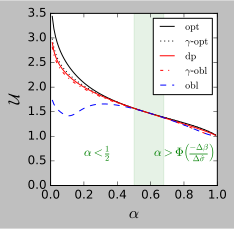

In [62]:
plot_us(a1s, us)
sigmasum = dm.sigmasum
aobl = st.norm.cdf((beta[0] - beta[1]) / (sigmasum[0] - sigmasum[1]))
plt.text(x=0.62, y=0.6, fontsize=12, s='$\\alpha > \\Phi\\left(\\frac{- \\Delta\\beta}{\\Delta\\hat\\sigma}\\right)$',  color='g')
plt.text(x=0.2, y=0.6, s='$\\alpha < \\frac{1}{2}$', fontsize=12, color='g')

x = np.arange(0, 1.001, 0.001)
plt.fill_between(x, y1=0, y2=3.5, where=(x < aobl)&(x > 1/2), alpha=0.1, color='g')

plt.legend(fontsize=10)
plt.savefig('../fig/appendix/biasA_smaller_biasB.pdf', bbox_inches='tight')

# Section 4.3 (different prior, no bias)

Case 1. $\mu_A = \mu_B$

In [17]:
dm = DecisionMaker(mu=[0, 0], sigma=[1, 2], sigmag=[3, 1], beta=[0, 0], pg=[0.4, 0.6])
a1s, ts, us, ps = get_us(dm, method='newton')

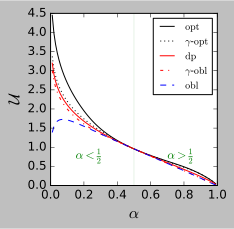

In [18]:
plot_us(a1s, us)
plt.axvline(0.5, alpha=0.1, color='g')
plt.text(x=0.15, y=0.7, s='$\\alpha < \\frac{1}{2}$', fontsize=12, color='g')
plt.text(x=0.7, y=0.7, s='$\\alpha > \\frac{1}{2}$', fontsize=12, color='g')
plt.legend(fontsize=10)
# plt.savefig('../fig/appendix/diff_prior_equal_mean.pdf', bbox_inches='tight')

Case 2. $\mu_A < \mu_B$

In [19]:
dm = DecisionMaker(mu=[0,1/2], sigma=[1, 1], sigmag=[3, 1], beta=[0, 0], pg=[0.4, 0.6])
a1s, ts, us, ps = get_us(dm, method='newton')
aobl = 1- st.norm.cdf((dm.mu[0] - dm.mu[1]) / (dm.sigmasum[1] - dm.sigmasum[0]))
aopt = 1 - st.norm.cdf(dm.sigmasum[0] * dm.sigmasum[1] / (dm.sigma[0]*dm.sigma[1])**2 * \
                       (dm.mu[0] - dm.mu[1]) / (dm.sigmasum[0]/dm.sigma[0]**2 - dm.sigmasum[1]/dm.sigma[1]**2))

Text(0.72, 1.2, '$\\alpha > \\alpha^{\\mathrm{max}}$')

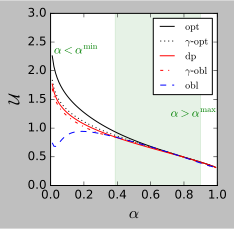

In [20]:
plot_us(a1s, us)
plt.legend(fontsize=10)
x = np.arange(0, 1.001, 0.001)
plt.text(x=0.02, y=2.3, fontsize=12, s='$\\alpha < \\alpha^{\mathrm{min}}$',  color='g')
plt.fill_between(x, y1=0, y2=3, where=(x < aopt)&(x > aobl), alpha=0.1, color='g')
plt.text(x=0.72, y=1.2, fontsize=12, s='$\\alpha > \\alpha^{\\mathrm{max}}$',  color='g')
# plt.savefig('../fig/appendix/diff_prior_diff_var_diff_mean.pdf', bbox_inches='tight')

Case 3. $\mu_A > \mu_B$

In [21]:
dm = DecisionMaker(mu=[1/2,0], sigma=[1, 1], sigmag=[3, 1], beta=[0, 0], pg=[0.4, 0.6])
a1s, ts, us, ps = get_us(dm, method='newton')
aobl = 1- st.norm.cdf((dm.mu[0] - dm.mu[1]) / (dm.sigmasum[1] - dm.sigmasum[0]))
aopt = 1 - st.norm.cdf(dm.sigmasum[0] * dm.sigmasum[1] / (dm.sigma[0]*dm.sigma[1])**2 * \
                       (dm.mu[0] - dm.mu[1]) / (dm.sigmasum[0]/dm.sigma[0]**2 - dm.sigmasum[1]/dm.sigma[1]**2))

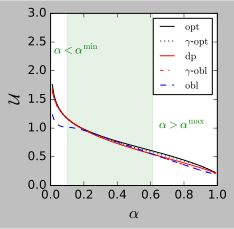

In [22]:
plot_us(a1s, us)
x = np.arange(0, 1.001, 0.001)
plt.text(x=0.02, y=2.3, fontsize=12, s='$\\alpha < \\alpha^{\mathrm{min}}$',  color='g')

plt.fill_between(x, y1=0, y2=3, where=(x > aopt)&(x<aobl), alpha=0.1, color='g')
plt.text(x=0.65, y=1, fontsize=12, s='$\\alpha > \\alpha^{\\mathrm{max}}$',  color='g')
plt.legend(fontsize=10)
# plt.savefig('../fig/appendix/diff_prior_diff_var_diff_mean2.pdf', bbox_inches='tight')